In [39]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

In [40]:
device="cuda" if torch.cuda.is_available() else "CPU"

In [41]:
device

'cuda'

In [42]:
val_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [43]:
train_dataset=datasets.CIFAR10(root="./data",train=True,download=True,transform=train_transform)
validation_dataset=datasets.CIFAR10(root="./data",train=False,download=True,transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
names=("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")

In [45]:
train_daraloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dataloader=DataLoader(validation_dataset,batch_size=32,shuffle=False)

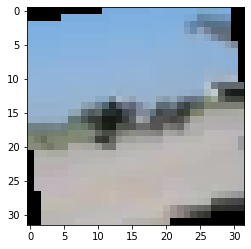

In [46]:
data_iter=iter(train_daraloader)
imgs,labels=data_iter.next()
img=imgs[0]
img_prmute=img.permute(1,2,0)
img_permute=0.5*img_prmute+0.5
img_permute=np.clip(img_permute,0,1)
plt.imshow(img_permute)

In [47]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier=nn.Linear(in_features=4*4*128,out_features=num_classes)
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [48]:
#!pip install efficientnet_pytorch

In [49]:
"""
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
"""

"\nfrom efficientnet_pytorch import EfficientNet\nmodel = EfficientNet.from_pretrained('efficientnet-b0')\n"

In [50]:
"""
for param in model.parameters():
    param.requires_grad=True
"""

'\nfor param in model.parameters():\n    param.requires_grad=True\n'

In [51]:
#model._fc=nn.Linear(1280,10)

In [52]:
model=CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [53]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=5e-4)

In [54]:
num_epochs=15
losses=[]
accs=[]
val_losses=[]
val_accs=[]
for epoch in range(num_epochs):
    running_loss=0.0
    running_acc=0.0
    for imgs,labels in train_daraloader:
        imgs=imgs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        output=model(imgs)
        loss=criterion(output,labels)
        loss.backward()
        running_loss+=loss.item()
        pred=torch.argmax(output,dim=1)
        running_acc+=torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /=len(train_daraloader)
    running_acc /=len(train_daraloader)
    losses.append(running_loss)
    accs.append(running_acc)

    val_running_loss=0.0
    val_running_acc=0.0
    for val_imgs,val_labels in validation_dataloader:
        val_imgs=val_imgs.to(device)
        val_labels=val_labels.to(device)
        val_output=model(val_imgs)
        val_loss=criterion(val_output,val_labels)
        val_running_loss+= val_loss.item()
        val_pred=torch.argmax(val_output,dim=1)
        val_running_acc+=torch.mean(val_pred.eq(val_labels).float())
    val_running_loss/=len(validation_dataloader)
    val_running_acc/=len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch:{},        loss:{},        acc:{},     val loss:{},        val acc:{}".format(epoch,running_loss,running_acc,val_running_loss,val_running_acc))

epoch:0,        loss:1.4212429253855197,        acc:0.4851047694683075,     val loss:1.0521867046721827,        val acc:0.631489634513855
epoch:1,        loss:0.9978168216448752,        acc:0.6480926275253296,     val loss:0.8650238777692325,        val acc:0.6945886611938477
epoch:2,        loss:0.848079091756678,        acc:0.703394889831543,     val loss:0.8000045185462354,        val acc:0.7198482155799866
epoch:3,        loss:0.7675153702611887,        acc:0.732945442199707,     val loss:0.7599715500974807,        val acc:0.7328274846076965
epoch:4,        loss:0.7166443228797889,        acc:0.7508597373962402,     val loss:0.7564078008595366,        val acc:0.7454073429107666
epoch:5,        loss:0.678241283330716,        acc:0.763015866279602,     val loss:0.6766175413474488,        val acc:0.7657747268676758
epoch:6,        loss:0.6525029443580984,        acc:0.7715930938720703,     val loss:0.6636980882944009,        val acc:0.7744608521461487
epoch:7,        loss:0.6230673677

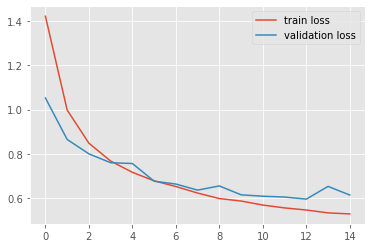

In [55]:
plt.style.use("ggplot")
plt.plot(losses,label="train loss")
plt.plot(val_losses,label="validation loss")
plt.legend()

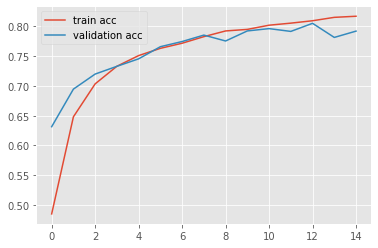

In [56]:
plt.plot(accs,label="train acc")
plt.plot(val_accs,label="validation acc")
plt.legend()